In [ ]:
# !pip install kmodes
# !pip install scikit-learn-extra

In [2]:
import pandas as pd
import numpy as np
import datetime, math
import sys, os, warnings
import matplotlib.pyplot as plt
from kmodes.kprototypes import KPrototypes
from kmodes.kmodes import KModes
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from PlotFigure import plot_values, plot_object
from Autoclass import find_best_cluster
import hdbscan

warnings.filterwarnings("ignore")

### Reading file

In [3]:
filename = 'KmeanClustering_sampledata_v3.csv'

### Parameter setting 

In [4]:
pma = 38
AutoCluster = True
category = 'personal','rfm','area','purchasetime','prefer'

method = 'KPrototypes' #'KMeans', 'KPrototypes', 'KMedoids', 'Kmodes'
if AutoCluster == False:
    numofCluster = 4
else:
    selectMethod = 'elbow' #'calinski-harabasz', 'davies-bouldin', 'silhouette', 'bic'

if 'rfm' in category:
    rfm_level = 'median' # 'median', 'mode', 'average'
    select_rfm = True
    if select_rfm:
        select_two = 'f', 'm'

In [5]:
type(category)

tuple

### PRE-processing

In [6]:
select_two = list(select_two)
category = list(category)
dconfig = pd.read_json('category_config.json')
readcols = {'key':['mid', 'pma_no_fin', 'qty', 'avg_qty'],
           'fmt': ['object', 'object', 'values', 'values']}

for cate in category:
    getkey = dconfig[cate]['key']
    getfmt = dconfig[cate]['format']
    readcols['key'].extend( getkey )
    readcols['fmt'].extend( getfmt )
readcols = pd.DataFrame(readcols)
df = pd.read_csv(filename, usecols = readcols['key'])
df = df[df['pma_no_fin']==pma]


In [7]:
df_preprocess = df.copy()
df_preprocess.fillna(' ', inplace=True)

if 'rfm' in category:
    getkey = dconfig['rfm']['key']
    tempdf_rfm = pd.DataFrame()
    rfm_level_key = []
    for idx_rfm in getkey:
        if rfm_level == 'average':
            num_split = np.mean(df_preprocess[idx_rfm].astype(float))
        elif rfm_level == 'median':
            num_split = np.median(df_preprocess[idx_rfm].astype(float))
        elif rfm_level == 'mode':
            num_split = np.mode(df_preprocess[idx_rfm].astype(float))
        idx_rfm_level = f'{idx_rfm}_level'
        rfm_level_key.append(idx_rfm_level)
        if 'recency' in idx_rfm :
            tempdf_rfm[idx_rfm_level] = [ '1'  if i <= num_split else '0' for i in df_preprocess[idx_rfm]]
        else:
            tempdf_rfm[idx_rfm_level] = [ '1'  if i >= num_split else '0' for i in df_preprocess[idx_rfm]]
    
    rfmlevel = []
    for r, f, m in zip(tempdf_rfm[tempdf_rfm.keys()[0]], tempdf_rfm[tempdf_rfm.keys()[1]], tempdf_rfm[tempdf_rfm.keys()[2]]):
        if select_rfm:
            if 'r' not in select_two:
                level = f'{f}{m}'
            elif 'f' not in select_two:
                level = f'{r}{m}'
            elif 'm' not in select_two:
                level = f'{r}{f}'       
        else:
            level = f'{r}{f}{m}'
        rfmlevel.append(level)
        
    df_preprocess['rfm_level']  = rfmlevel    
    labelencoder_rfm = LabelEncoder()
    df_preprocess['rfm_level'] = labelencoder_rfm.fit_transform(df_preprocess['rfm_level'])
    df_preprocess['rfm_level'] = df_preprocess['rfm_level'].astype(object)
    
for objkey in readcols['key'][readcols['fmt']=='object']:
    try:
        if 'area' not in objkey:
            globals()[f'labelencoder_{objkey}'] = LabelEncoder()
            df_preprocess[objkey] = globals()[f'labelencoder_{objkey}'].fit_transform(df_preprocess[objkey])
            df_preprocess[objkey] = df_preprocess[objkey].astype(object)
    except:
        pass

df_preprocess = df_preprocess.replace(' ',0)   
df_4cluster = df_preprocess.copy()
df_4cluster = df_4cluster.drop(['mid', 'pma_no_fin', 'rfm_recency', 'rfm_frequency', 'rfm_monetary'], axis = 1) 
    
catobj_Name =  list(df_4cluster.select_dtypes('object').columns)
catobj_Pos = [df_4cluster.columns.get_loc(col) for col in list(df_4cluster.select_dtypes('object').columns)] 




### Makedir

In [8]:
savedir = f'PMA-{pma}'
if not os.path.isdir(savedir):
        os.makedirs(savedir)
else:
    gettime = os.path.getctime(savedir)
    datetimeObj = datetime.datetime.fromtimestamp(gettime)
    dateStr = datetimeObj.strftime('%Y%m%d_%H%M%S')
    os.makedirs(f'{savedir}/{dateStr}')
    cmd = '''
    mv %(savedir)s/Group* %(savedir)s/%(dateStr)s
    mv %(savedir)s/*.log %(savedir)s/%(dateStr)s
    mv %(savedir)s/*.png %(savedir)s/%(dateStr)s
    '''%locals()
    os.system(cmd)
    

mv: rename PMA-38/Group* to PMA-38/20230725_160426/Group*: No such file or directory
mv: rename PMA-38/*.log to PMA-38/20230725_160426/*.log: No such file or directory
mv: rename PMA-38/*.png to PMA-38/20230725_160426/*.png: No such file or directory


In [63]:
clusterer = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=2)

In [64]:
clusterer.fit(df_4cluster)

HDBSCAN(min_cluster_size=2, min_samples=2)

In [65]:
clusterer.labels_

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1])

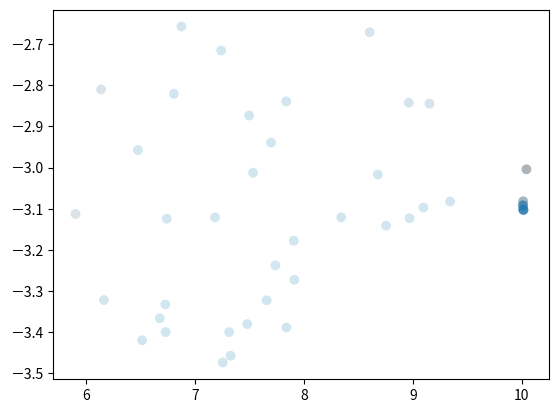

In [66]:
from sklearn.manifold import TSNE
import seaborn as sns
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]

projection = TSNE().fit_transform(df_4cluster)
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.5)